In [2]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from vpl_model.networks import ContrastiveNet, MultiLayerContrastiveNet
from vpl_model.utils import generate_tuned_weights, check_dir
from vpl_model.tasks import AngleDiscriminationTask


In [3]:
# Task parameters
training_orientation = 90.0
orientation_diff = 1
input_size = 80
signal_amp = 1.0
signal_bandwidth = 15
output_amp = 1.0

# Model parameters
hidden_dim = 40
learning_rate = 0.001
test_epochs = 10
epochs = 50000
tuned_neurons_width = 10
lr_W2_W1 = 1.0


all_regimes = {"contrastive_hebb": {"gamma": 1.0, "eta": 0.0},
               "gradient_descent": {"gamma": 0.0, "eta": 0.0},
               "quasi_predictive": {"gamma": -1.0, "eta": 0.0},
               "hebbian": {"gamma": 0, "eta": 0.01},
               "anti_hebbian": {"gamma": 0, "eta": -0.01},}

In [4]:
data = AngleDiscriminationTask(training_orientation=training_orientation,
                               orientation_diff=orientation_diff,
                               input_size=input_size,
                               signal_amp=signal_amp,
                               signal_bandwidth=signal_bandwidth,
                               output_amp=output_amp)

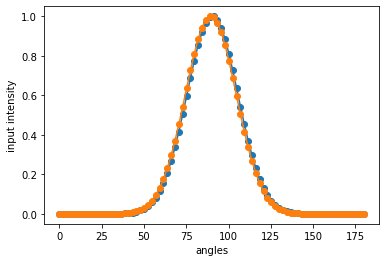

In [5]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(data.angles, data.pos_gaussian, "-o")
ax.plot(data.angles, data.neg_gaussian, "-o")
ax.set_xlabel("angles")
ax.set_ylabel("input intensity")
plt.show()

In [6]:
W1_0 = generate_tuned_weights(input_size, hidden_dim=hidden_dim, angles=data.angles, tuning_width=tuned_neurons_width)
# W2_0 = np.random.normal(scale=1e-10, size=(int(data.output_size), hidden_dim))
W2_0 = np.zeros((int(data.output_size), hidden_dim))

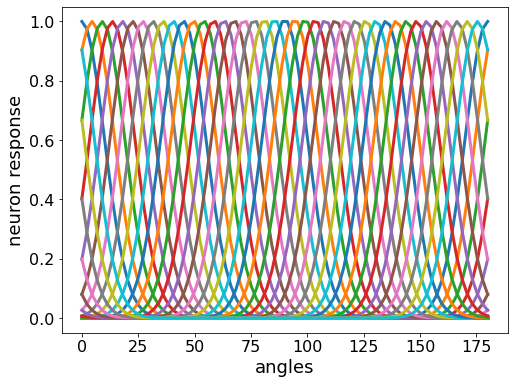

In [12]:
FONTSIZE = 18
lw = 3
f, ax = plt.subplots(1, 1, figsize=(8, 6))
for i in range(hidden_dim):
    ax.plot(data.angles, W1_0[i, :], lw=lw)
ax.set_xlabel("angles", fontsize=FONTSIZE)
ax.set_ylabel("neuron response", fontsize=FONTSIZE)
ax.tick_params(axis='both', which='major', labelsize=FONTSIZE-2)
plt.show()

In [7]:
regime_results = {}
for key, values in all_regimes.items():
    aux_dict = {}
    total_loss = []
    grad1_list = []
    grad2_list = []
    
    net = ContrastiveNet(W1_0=W1_0, W2_0=W2_0, gamma=values["gamma"], eta=values["eta"], learning_rate=learning_rate,
                         lr_W2_W1=lr_W2_W1)
    for i in tqdm(range(epochs)):
        x, y = data.full_batch()
        #print(x.shape, y.shape)
        h_ff, y_hat = net.forward(x)
        #print(h_ff.shape, y_hat.shape)
        W1_grad, W2_grad = net.update(x, y, y_hat, h_ff)
        grad1_list.append(W1_grad)
        grad2_list.append(W2_grad)
        total_loss.append(net.loss(y_hat, y))
    RSM = h_ff[:, :, 0] @ h_ff[:, :, 0].T
    aux_dict["RSM"] = RSM
    aux_dict["loss"] = total_loss
    aux_dict["learned_W1"] = net.W1
    aux_dict["learned_W2"] = net.W2
    aux_dict["W1_grad"] = grad1_list
    aux_dict["W2_grad"] = grad2_list
    regime_results[key] = aux_dict

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [04:00<00:00, 207.56it/s]


In [8]:
def slope_per_angle(W):
    # print(W.shape, W[:, 0][:, np.newaxis].shape)
    slopes = np.diff(np.concatenate([W, W[:, 1][:, np.newaxis]], axis=1), axis=1)
    slope_ori = np.mean(np.abs(slopes), axis=0)
    return slope_ori

def change_in_slope(W_new, W_0):
    slope_0 = slope_per_angle(W_0)
    slope_1 = slope_per_angle(W_new)
    return slope_1 - slope_0

def amplitude_change(W_new, W_0):
    amp0 = np.mean(W_0, axis=0)
    amp1 = np.mean(W_new, axis=0)
    return amp1 - amp0

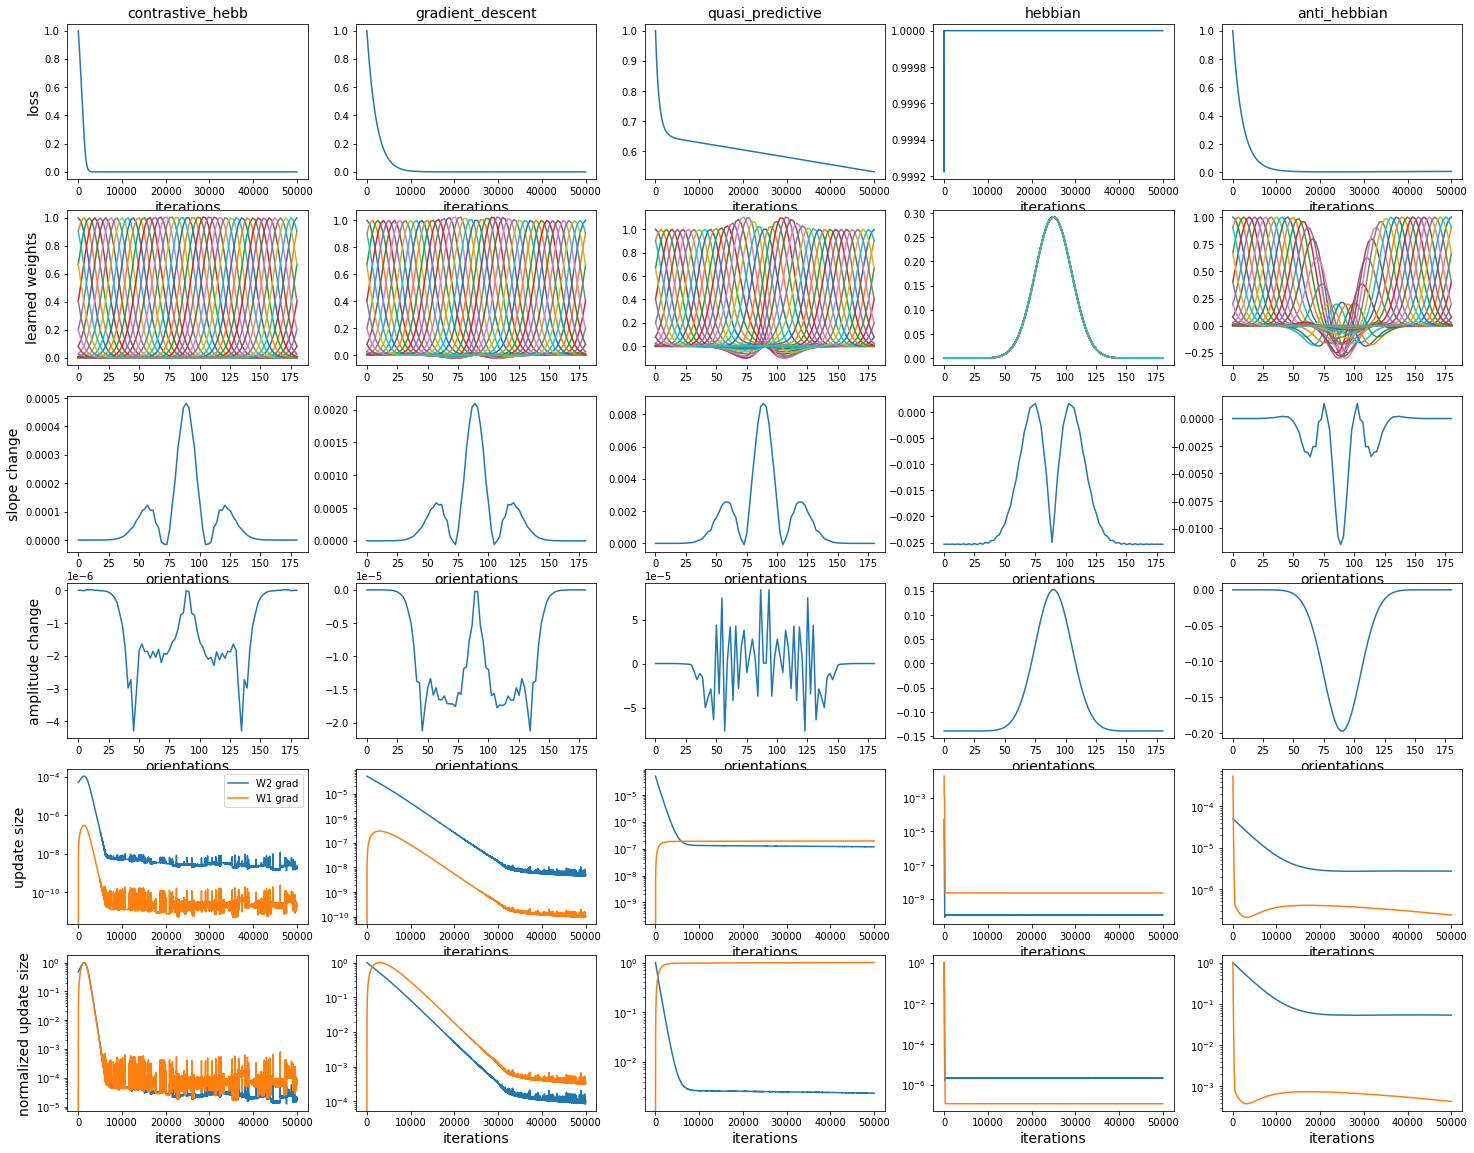

In [9]:
fontsize=14
f, ax = plt.subplots(6, len(regime_results), figsize=(5*len(regime_results), 20))
for i, (key, value) in enumerate(regime_results.items()):
    ax[0, i].plot(value["loss"])
    ax[0, i].set_title(key, fontsize=fontsize)
    ax[0, i].set_xlabel("iterations", fontsize=fontsize)
    
    for j in range(hidden_dim):
        ax[1, i].plot(data.angles, value["learned_W1"][j, :])
    
    # ax[2, i].plot(data.angles, slope_per_angle(value["learned_W1"]))
    ax[2, i].plot(data.angles, change_in_slope(value["learned_W1"], W1_0))
    ax[2, i].set_xlabel("orientations", fontsize=fontsize)
    
    ax[3, i].plot(data.angles, amplitude_change(value["learned_W1"], W1_0))
    ax[3, i].set_xlabel("orientations", fontsize=fontsize)
    
    plot_index = 4
    ax[plot_index, i].plot(value["W2_grad"], label="W2 grad")
    ax[plot_index, i].plot(value["W1_grad"], label="W1 grad")
    ax[plot_index, i].set_yscale("log")
    ax[plot_index, i].set_xlabel("iterations", fontsize=fontsize)
    
    plot_index = 5
    ax[plot_index, i].plot(value["W2_grad"]/np.amax(value["W2_grad"]), label="norm W2 grad")
    ax[plot_index, i].plot(value["W1_grad"]/np.amax(value["W1_grad"]), label="norm W1 grad")
    ax[plot_index, i].set_yscale("log")
    ax[plot_index, i].set_xlabel("iterations", fontsize=fontsize)
    

ax[0, 0].set_ylabel("loss", fontsize=fontsize)
ax[1, 0].set_ylabel("learned weights", fontsize=fontsize)
ax[2, 0].set_ylabel("slope change", fontsize=fontsize)
ax[3, 0].set_ylabel("amplitude change", fontsize=fontsize)
ax[4, 0].legend()
ax[4, 0].set_ylabel("update size", fontsize=fontsize)
ax[5, 0].set_ylabel("normalized update size", fontsize=fontsize)

plt.savefig("hard_task.pdf", bbox_inches="tight")

#ax[1, i].imshow(value["RSM"])
    #print(value["RSM"].shape)

In [10]:
import pickle
pickle.dump(regime_results, open("regime_results", "wb"), protocol=pickle.HIGHEST_PROTOCOL)